### Modelo AlexNet from Scratch en PyTorch

En este notebook se programa el modelo de AlexNet en PyTorch desde cero y se entrena y valida con el dataset de CIFAR-10


In [ ]:
# Importamos las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Configuramos el dispositivo a utilizar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
device

device(type='cuda')

In [ ]:
# 1. Cargamos y normalizamos el dataset CIFAR10
transform = transforms.Compose([
    transforms.Resize(227),  # Para esta version de AlexNet se utilizan imagenes de 227x227
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# 2. Definimos la red neuronal

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.cn1 = nn.Conv2d(3, 96, 11, stride=4,padding=0)
        self.cn2 = nn.Conv2d(96, 256, 5, stride=1,padding=2)
        self.cn3 = nn.Conv2d(256, 384, 3, stride=1,padding=1)
        self.cn4 = nn.Conv2d(384, 384, 3, stride=1,padding=1)
        self.cn5 = nn.Conv2d(384, 256, 3, stride=1,padding=1)
        self.fc1 = nn.Linear(9216, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.cn1(x),inplace=True)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = F.relu(self.cn2(x),inplace=True)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = F.relu(self.cn3(x),inplace=True)
        x = F.relu(self.cn4(x),inplace=True)
        x = F.relu(self.cn5(x),inplace=True)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = x.view(-1, 9216)
        x = F.relu(F.dropout(self.fc1(x),training=self.training,inplace=False),inplace=True)
        x = F.relu(F.dropout(self.fc2(x),training=self.training,inplace=False),inplace=True)
        x = self.fc3(x)
        return x

In [ ]:
# 3. Definimos la funcion de perdida y el optimizador y asignamos el modelo a la GPU

model = AlexNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [25]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# El modelo tiene 58 millones parametros!
count_params( model )

58322314

In [ ]:
for epoch in range(5):  # Entrenamos por 5 epocas
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        labels = labels.long()
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999: 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
model.eval()
print('Finished Training')

[1,  2000] loss: 2.300
[1,  4000] loss: 2.020
[1,  6000] loss: 1.752
[1,  8000] loss: 1.573
[1, 10000] loss: 1.468
[1, 12000] loss: 1.373
[2,  2000] loss: 1.240
[2,  4000] loss: 1.180
[2,  6000] loss: 1.078
[2,  8000] loss: 1.021
[2, 10000] loss: 0.998
[2, 12000] loss: 0.949
[3,  2000] loss: 0.871
[3,  4000] loss: 0.844
[3,  6000] loss: 0.823
[3,  8000] loss: 0.801
[3, 10000] loss: 0.777
[3, 12000] loss: 0.761
[4,  2000] loss: 0.654
[4,  4000] loss: 0.668
[4,  6000] loss: 0.652
[4,  8000] loss: 0.649
[4, 10000] loss: 0.652
[4, 12000] loss: 0.621
[5,  2000] loss: 0.498
[5,  4000] loss: 0.525
[5,  6000] loss: 0.532
[5,  8000] loss: 0.540
[5, 10000] loss: 0.528
[5, 12000] loss: 0.530
Finished Training


In [ ]:
# 7. Validamos el modelo con el conjunto de testing
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 79.16 %


El modelo tiene un accuracy de 79.16%!!!

In [ ]:

# 8. Validamos el modelo con el conjunto de testing por clases
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]:5s} : {100 * class_correct[i] / class_total[i]:.2f} %')

Accuracy of plane : 78.00 %
Accuracy of car   : 84.50 %
Accuracy of bird  : 72.60 %
Accuracy of cat   : 69.10 %
Accuracy of deer  : 76.70 %
Accuracy of dog   : 67.90 %
Accuracy of frog  : 84.10 %
Accuracy of horse : 82.50 %
Accuracy of ship  : 87.10 %
Accuracy of truck : 89.10 %


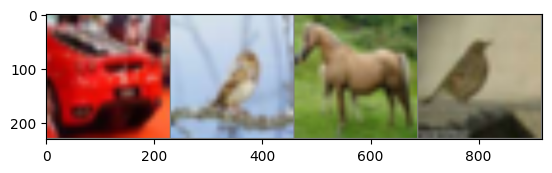

 car || bird || horse || bird


In [ ]:
# Observamos algunos ejemplos
def imageshow(image):
   image = image/2 + 0.5
   npimage = image.numpy()
   plt.imshow(np.transpose(npimage, (1, 2, 0)))
   plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))

print(' ' + ' || '.join(classes[labels[j]]
        for j in range(num_images)))

